# AAMAS 2022 Tutorial – Graph Neural Networks: Learning Representations of Robot Team Coordination Problems

# Coding Session
This notebook serves as the coding session of the [AAMAS 2022 Tutorial – Graph Neural Networks: Learning Representations of Robot Team Coordination Problems](https://core-robotics.gatech.edu/2022/01/18/aamas2022_tutorial_gnn_robot/).

The notebook provides a hands-on tutorial for how to get up and running with graph neural networks for coordination problems. In particular, we will look into the [ScheduleNet](https://link.springer.com/article/10.1007/s10514-021-09997-2) architecture, a heterogenous graph neural network-based solver for MRC problems under temporal and spatial constraints. 

# Part 1 Heterogeneous Graph Neural Networks with Deep Graph Library

# Environment Setup

## Basic Setup
To enable CUDA availability, select GPU as hardware accelerator in **Edit->Notebook settings**

Check system specs

In [ ]:
!nvcc -V
!python --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Python 3.7.13


Import packages provided by Google Colab

In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

Check GPU availability

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.get_device_name(0))

1.11.0+cu113
False
0


## Install Deep Graph Library

Select the correct command based on Python and CUDA version from https://www.dgl.ai/pages/start.html

In [ ]:
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

In [ ]:
# use this to install CPU-only version
!pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 6.2 MB 2.8 MB/s 
     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 51 kB 390 kB/s 
     |████████████████████████████████| 103 kB 31.9 MB/s 
     |████████████████████████████████| 10.9 MB 63.9 MB/s 
     |████████████████████████████████| 109 kB 64.2 MB/s 
     |████████████████████████████████| 596 kB 54.4 MB/s 
     |████████████████████████████████| 42 kB 788 kB/s 
     |████████████████████████████████| 3.1 MB 47.4 MB/s 
     |████████████████████████████████| 546 kB 57.3 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 100 kB 9.6 MB/s 
     |████████████████████████████████| 90 kB 8.3 MB/s 
     |████████████████████████████████| 121 kB 44.4 MB/s 
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 1.8.6
    Uninsta

Verify installation

In [ ]:
import dgl
print(dgl.__version__)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
0.8.1


DGL supports PyTorch, MXNet and Tensorflow backends. 
DGL will choose the backend on the following options (high priority to low priority)

* Use the ``DGLBACKEND`` environment variable:

   - You can use ``DGLBACKEND=[BACKEND] python gcn.py ...`` to specify the backend
   - Or ``export DGLBACKEND=[BACKEND]`` to set the global environment variable 

* Modify the ``config.json`` file under "~/.dgl":

   - You can use ``python -m dgl.backend.set_default_backend [BACKEND]`` to set the default backend

For this tutorial, we use PyTorch as backend.

# Introduction to Graphs

Graphs express **entities** (**nodes**) along with their **relations** (edges), and both nodes and edges can be typed (e.g., `"user"` and `"item"` are two different types of nodes). DGL provides a graph-centric programming abstraction with its core data structure - `dgl.DGLGraph`. `dgl.DGLGraph` provides its interface to handle a graph's structure, its node/edge features, and the resulting computations that can be performed using these components.

## Basic Definitions

A graph $G=(V, E)$ is a structure used to represent entities and their relations. It consists of two sets -- the set of nodes $V$ (also called vertices) and the set of edges $E$ (also called arcs). An edge $(u, v) \in E$ connecting a pair of nodes $u$ and $v$ indicates that there is a relation between them.

The relation can either be **undirected**, e.g., capturing symmetric
relations between nodes, or **directed**, capturing asymmetric relations.

* For example, if a graph is used to model the friendships relations of people in a social network, then the edges will be undirected as friendship is mutual; however, if the graph is used to model how people follow each other on Twitter, then the edges are directed.

Graphs can be **weighted** or **unweighted**.

* In a weighted graph, each edge is associated with a scalar weight or a high-dimension weight feature. For example, such weights might represent lengths or connectivity strengths.

Graphs can also be either **homogeneous** or **heterogeneous**.

* In a homogeneous graph, all the nodes represent instances of the same type and all the edges represent relations of the same type. For instance, a network of homogeneous robots is a graph consisting of `robots` and their connections, representing the same entity type.

* In a heterogeneous graph, the nodes and edges can be of different types. For
instance, the graph encoding a marketplace will have `buyer`, `seller`, and `product` nodes that are connected via `wants-to-buy`, `has-bought`,`is-customer-of`, and `is-selling` edges.

* The bipartite graph is a special, commonly-used type of heterogeneous graph, where edges exist between nodes of two different types. For example, in a recommender system, one can use a bipartite graph to represent the interactions between `users` and `item`s.

## Representing Nodes and Edges

DGL represents each node by a unique integer, called its **node ID**, and each edge by a pair of integers corresponding to the IDs of its end nodes. DGL assigns to each edge a unique integer, called its **edge ID**, based on the order in which it was added to the graph.

* The numbering of node and edge IDs starts from 0. In DGL, all the edges are directed, and an edge $(u,v)$ indicates that the direction goes from node $u$ to node $v$.

To specify multiple nodes, DGL uses a 1-D integer tensor (i.e., PyTorch's tensor, TensorFlow's Tensor, or MXNet's ndarray) of node IDs. DGL calls this format "node-tensors". To specify multiple edges, it uses a tuple of node-tensors $(U, V)$. $(U[i], V[i])$ decides an edge from $U[i]$ to $V[i]$.

One way to create a `dgl.DGLGraph` is to use the `dgl.graph` method, which takes
as input a set of edges.

The following code snippet uses the `dgl.graph` method to create a `dgl.DGLGraph` corresponding to the four-node graph shown below and illustrates some of its APIs for querying the graph's structure.

<img src="https://data.dgl.ai/asset/image/user_guide_graphch_1.png" width="300">

In [ ]:
# edges 0->1, 0->2, 0->3, 1->3
u, v = torch.tensor([0, 0, 0, 1]), torch.tensor([1, 2, 3, 3])
# number of nodes are either inferred from the max node IDs in the given edges
g = dgl.graph((u, v))
print(g)

# Node IDs
print(g.nodes())

# Edge end nodes
print(g.edges())

# Edge end nodes and edge IDs
print(g.edges(form='all'))

Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 1, 2, 3])
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]))
(tensor([0, 0, 0, 1]), tensor([1, 2, 3, 3]), tensor([0, 1, 2, 3]))


In [ ]:
# If the node with the largest ID is isolated (meaning no edges),
# then one needs to explicitly set the number of nodes
g2 = dgl.graph((u, v), num_nodes=8)
print(g2)

Graph(num_nodes=8, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


When visualizing a homogeneous graph, we first convert it to a [NetworkX](https://networkx.org/) instance

Color names in matplotlib: https://matplotlib.org/3.5.0/_images/sphx_glr_named_colors_003_2_0x.png

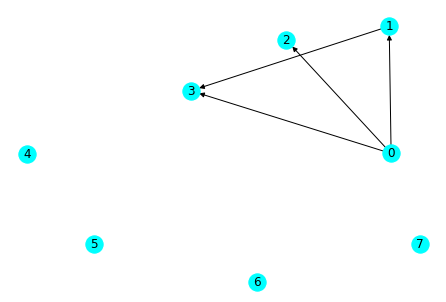

In [ ]:
nx_g = g2.to_networkx()

# node positioning algorithms for graph drawing.
pos = nx.kamada_kawai_layout(nx_g)
# pos = nx.circular_layout(nx_g)
# pos = nx.random_layout(nx_g)

plt.figure()
nx.draw(nx_g, pos, with_labels=True, node_color='aqua')
# also draw the edge info
#nx.draw_networkx_edge_labels(nx_g, pos, font_color='red')
plt.show()

## Node and Edge Features

The nodes and edges of a `dgl.DGLGraph` can have several **user-defined named features** for storing graph-specific properties of the nodes and edges. These features can be accessed via the `dgl.DGLGraph.ndata` and `dgl.DGLGraph.edata` interface.


In [ ]:
g = dgl.graph(([0, 0, 5, 6], [1, 2, 2, 0])) # 7 nodes, 4 edges
print(g)

# creates node feature named 'x' and edge feature named 'w'
g.ndata['x'] = torch.ones(g.num_nodes(), 2)           # node feature of length 2
g.edata['w'] = torch.ones(g.num_edges(), dtype=torch.int32)  # scalar integer feature
print('after feature assignment')
print(g)
print("get node 1's feature 'x'")
print(g.ndata['x'][1])
print("get features of edge 0 and 3")
g.edata['w'][torch.tensor([0, 3])]

Graph(num_nodes=7, num_edges=4,
      ndata_schemes={}
      edata_schemes={})
after feature assignment
Graph(num_nodes=7, num_edges=4,
      ndata_schemes={'x': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'w': Scheme(shape=(), dtype=torch.int32)})
get node 1's feature 'x'
tensor([1., 1.])
get features of edge 0 and 3


tensor([1, 1], dtype=torch.int32)

In [ ]:
# creates node feature named 'y'
# different names can have different shapes
g.ndata['y'] = torch.randn(g.num_nodes(), 5)
print("get node 1's feature 'y'")
print(g.ndata['y'][1])

# the features of nodes and edges can have the same name
g.ndata['w'] = torch.randn(g.num_nodes(), 7)
print("get node 1's feature 'w'")
print(g.ndata['w'][1])

get node 1's feature 'y'
tensor([-0.6134, -1.3947, -0.7612, -0.0191,  0.0659])
get node 1's feature 'w'
tensor([-0.8260,  1.0193,  0.4343, -1.0865,  2.0654,  0.4865, -0.7720])


Important facts about the `ndata`/`edata` interface:

- Only features of **numerical types** (e.g., float, double, and int) are allowed. They can   be scalars, vectors or multi-dimensional tensors.
- Each node feature has a unique name and each edge feature has a unique name.
  The features of nodes and edges **can have** the same name.
- A feature is created via tensor assignment, which assigns a feature to each
  node/edge in the graph. The leading dimension of that tensor must be equal to the number of nodes/edges in the graph. You cannot assign a feature to a subset of the nodes/edges in the graph.
- Features of the same name (under the same node/edge type) must have the same dimensionality and data type.
- The feature tensor is in row-major layout -- each row-slice stores the feature of one node or edge.

# Heterogeneous Graphs

A heterogeneous graph can have nodes and edges of different types. In DGL, nodes/edges of different types have **independent ID space and feature storage**. For example in the figure below, the user and game node IDs both start from zero and they have different features.

<img src=https://data.dgl.ai/asset/image/user_guide_graphch_2.png width="605">

## Creating a Heterogeneous Graph

In DGL, a heterogeneous graph (**heterograph** for short) is specified with a series of graphs as below, **one per relation**.

Each relation is a string triplet ``(source node type, edge type, destination node type)``, called **canonical edge types**.

In [ ]:
# Create a heterograph with 3 node types and 4 edges types.
graph_data = {
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 0, 1, 1, 2, 2]), torch.tensor([1, 2, 0, 2, 0, 1])),
   ('robot', 'executes', 'task'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('task', 'in', 'location'): (torch.tensor([0, 1, 2, 3]), torch.tensor([0, 0, 1, 1])),
   ('location', 'near', 'location'): (torch.tensor([0]), torch.tensor([1]))
}
g = dgl.heterograph(graph_data)
print(g)

Graph(num_nodes={'location': 2, 'robot': 3, 'task': 4},
      num_edges={('location', 'near', 'location'): 1, ('robot', 'communicates', 'robot'): 6, ('robot', 'executes', 'task'): 2, ('task', 'in', 'location'): 4},
      metagraph=[('location', 'location', 'near'), ('robot', 'robot', 'communicates'), ('robot', 'task', 'executes'), ('task', 'location', 'in')])


In [ ]:
print('Node types:', g.ntypes)
print('Edge types:',g.etypes)
print('Edge types (in full)')
print(g.canonical_etypes)

Node types: ['location', 'robot', 'task']
Edge types: ['near', 'communicates', 'executes', 'in']
Edge types (in full)
[('location', 'near', 'location'), ('robot', 'communicates', 'robot'), ('robot', 'executes', 'task'), ('task', 'in', 'location')]


In [ ]:
# Note that homogeneous and bipartite graphs are just special heterogeneous graphs with one relation.
print('A homogeneous graph')
print(dgl.heterograph({('location', 'near', 'location'): (u, v)}))
print('A bipartite graph')
print(dgl.heterograph({('robot', 'executes', 'task'): (u, v)}))

A homogeneous graph


NameError: ignored

## Graph Visualization

The **metagraph** associated with a heterogeneous graph is the schema of the graph. It specifies type constraints on the sets of nodes and edges between the nodes.

* A node $u$ in a metagraph corresponds to a node type in the associated heterograph.

* An edge $(u, v)$ in a metagraph indicates that there are edges from nodes of type $u$ to nodes of type $v$ in the associated heterograph.

In [ ]:
g.metagraph().edges()

OutMultiEdgeDataView([('location', 'location'), ('robot', 'robot'), ('robot', 'task'), ('task', 'location')])

We can plot the metagraph using `pygraphviz`

In [ ]:
# graphviz is installed in Colab server, but need lib to work
# credits to: https://gist.github.com/korakot/a80c04a1945b06e2f4a053f92fecfbf9
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 42 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.

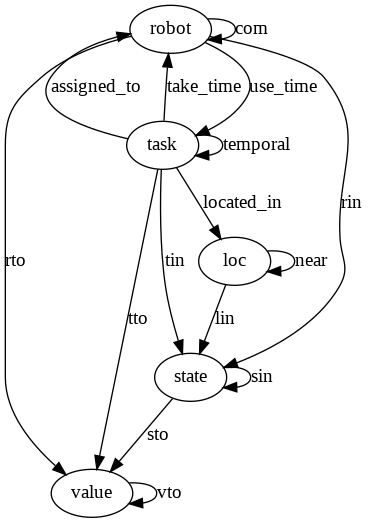

In [ ]:
import cv2
import pygraphviz as pgv
from google.colab.patches import cv2_imshow

# helper function
def plot_graph(nxg, save_name):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw(save_name+'.png')

plot_graph(g.metagraph(), 'base_graph')

img = cv2.imread('base_graph.png')

cv2_imshow(img)

To visualize the graph instance, we first convert it to a homogenous graph. More on this in later part of the tutorial.

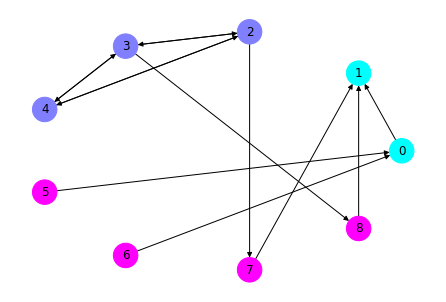

In [ ]:
homo_g = dgl.to_homogeneous(g)
nx_g = dgl.to_networkx(homo_g, node_attrs=['_TYPE'], edge_attrs=['_TYPE'])

plt.figure()
pos = nx.circular_layout(nx_g)
node_color = homo_g.ndata['_TYPE']
nx.draw(nx_g, pos, with_labels = True, node_color=node_color, node_size=600, cmap=plt.cm.cool)
plt.show()

## Working with Multiple Types

When multiple node/edge types are introduced, users need to specify the particular node/edge type when invoking a DGLGraph API for type-specific information. In addition, nodes/edges of different types have separate IDs.



In [ ]:
# Get the number of all nodes in the graph
g.num_nodes()

9

In [ ]:
# Get the number of robot nodes
g.num_nodes('task')

4

In [ ]:
# Nodes of different types have separate IDs,
# hence not well-defined without a type specified
g.nodes()

# the following one is correct
#g.nodes('xxx')

To set/get features for a specific node/edge type, DGL provides two new types of syntax - `g.nodes['node_type'].data['feat_name']` and `g.edges['edge_type'].data['feat_name']`.

In [ ]:
# Set/get feature 'hv' for nodes of type 'robot'
g.nodes['robot'].data['hv'] = torch.tensor([5, 1, 4]).reshape(3, 1)
g.nodes['robot'].data['hv']

tensor([[5],
        [1],
        [4]])

In [ ]:
# Set/get feature 'he' for edge of type 'treats'
g.edges['executes'].data['he'] = torch.randint(1, 10, (2,1))
g.edges['executes'].data['he']

tensor([[3],
        [1]])

If the graph only has one node/edge type, there is no need to specify the node/edge type.

In [ ]:
robot_g = dgl.heterograph({
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('robot', 'near', 'robot'): (torch.tensor([0, 1]), torch.tensor([2, 3]))
})

# To set/get feature with a single type, no need to use the new syntax
robot_g.ndata['hv'] = torch.randn(4, 2)
robot_g.ndata['hv']

tensor([[-0.9020,  1.5930],
        [ 0.8037,  0.0438],
        [-0.0419,  0.5689],
        [ 1.1580, -0.6588]])

When the edge type **uniquely determines** the types of source and destination nodes, one can just use one string instead of a string triplet to specify the edge type.

* For the example graph, it is safe to just use ``'communicates'``, ``'near'``, to refer to the specific relations.

## Edge Type Subgraph

One can create a subgraph of a heterogeneous graph by specifying the relations to retain, with features copied if any.

In [ ]:
# Create a heterograph with 3 node types and 4 edges types.
graph_data = {
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('robot', 'executes', 'task'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('task', 'in', 'location'): (torch.tensor([0, 1, 2, 3]), torch.tensor([0, 0, 1, 1])),
   ('location', 'near', 'location'): (torch.tensor([1]), torch.tensor([2]))
}
g = dgl.heterograph(graph_data)
g.nodes['robot'].data['hv'] = torch.ones(3, 2)

# Retain relations ('robot', 'communicates', 'robot') and ('robot', 'executes', 'task')
# All nodes for 'robot' and 'task' will be retained
eg = dgl.edge_type_subgraph(g, [('robot', 'communicates', 'robot'),
                                ('robot', 'executes', 'task')])
print(eg)

# The associated features will be copied as well
eg.nodes['robot'].data['hv']

Graph(num_nodes={'robot': 3, 'task': 4},
      num_edges={('robot', 'communicates', 'robot'): 2, ('robot', 'executes', 'task'): 2},
      metagraph=[('robot', 'robot', 'communicates'), ('robot', 'task', 'executes')])


tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

## Converting Heterogeneous Graphs to Homogeneous Graphs

Heterographs provide a clean interface for managing nodes/edges of different types and their associated features. This is particularly helpful when:

1. The features for nodes/edges of different types have different data types or sizes.
2. We want to apply different operations to nodes/edges of different types.

If the above conditions do not hold and one does not want to distinguish node/edge types in modeling, then DGL allows converting a heterogeneous graph to a homogeneous graph with `dgl.DGLGraph.to_homogeneous` API. It proceeds as follows:

1. Relabels nodes/edges of all types using consecutive integers starting from 0
2. Merges the features across node/edge types specified by the user.

In [ ]:
robot_g = dgl.heterograph({
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('robot', 'executes', 'task'): (torch.tensor([0, 1]), torch.tensor([2, 3]))
})

robot_g.nodes['robot'].data['hv'] = torch.ones(3, 1)
robot_g.nodes['task'].data['hv'] = torch.ones(4, 1)
robot_g.edges['communicates'].data['he'] = torch.ones(2, 1)
robot_g.edges['executes'].data['he'] = torch.ones(2, 2)

# By default, it does not merge any features
hg = dgl.to_homogeneous(robot_g)
print(hg.ndata)
print('hv' in hg.ndata)

{'_ID': tensor([0, 1, 2, 0, 1, 2, 3]), '_TYPE': tensor([0, 0, 0, 1, 1, 1, 1])}
False


In [ ]:
# Copy edge features
# For feature copy, it expects features to have
# the same size and dtype across node/edge types
# this gives an error
hg = dgl.to_homogeneous(robot_g, edata=['he'])

In [ ]:
# Copy node features
hg = dgl.to_homogeneous(robot_g, ndata=['hv'])
hg.ndata['hv']

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

The original node/edge types and type-specific IDs are stored in `dgl.DGLGraph.ndata` and `dgl.DGLGraph.edata`.

In [ ]:
# Order of node types in the heterograph
print(robot_g.ntypes)

# Original node types
print(hg.ndata[dgl.NTYPE])

# Original type-specific node IDs
print(hg.ndata[dgl.NID])

['robot', 'task']
tensor([0, 0, 0, 1, 1, 1, 1])
tensor([0, 1, 2, 0, 1, 2, 3])


In [ ]:
# Order of edge types in the heterograph
print(robot_g.etypes)

# Original edge types
print(hg.edata[dgl.ETYPE])

# Original type-specific edge IDs
print(hg.edata[dgl.EID])

['communicates', 'executes']
tensor([0, 0, 1, 1])
tensor([0, 1, 0, 1])


For modeling purposes, one may want to group some relations together and apply the same operation to them. To address this need, one can first take an edge type subgraph of the heterograph and then convert the subgraph to a homogeneous graph.

In [ ]:
graph_data = {
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('robot', 'executes', 'task'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('task', 'in', 'location'): (torch.tensor([0, 1, 2, 3]), torch.tensor([0, 0, 1, 1])),
   ('location', 'near', 'location'): (torch.tensor([1]), torch.tensor([2]))
}
g = dgl.heterograph(graph_data)
sub_g  = dgl.edge_type_subgraph(g, [('robot', 'communicates', 'robot'),
                                ('robot', 'executes', 'task')])

h_sub_g = dgl.to_homogeneous(sub_g)
h_sub_g

Graph(num_nodes=7, num_edges=4,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

# Writing Message Passing Code

## Message Passing Paradigm

Let $x_v\in\mathbb{R}^{d_1}$ be the feature for node $v$, and $w_{e}\in\mathbb{R}^{d_2}$ be the feature for edge $({u}, {v})$. The **message passing paradigm** defines the following node-wise and edge-wise computation at step $t+1$:

\begin{equation}
\text{Edge-wise: } m_{e}^{(t+1)} = \phi \left( x_v^{(t)}, x_u^{(t)}, w_{e}^{(t)} \right) , ({u}, {v},{e}) \in \mathcal{E}.
\end{equation}

\begin{equation}
\text{Node-wise: } x_v^{(t+1)} = \psi \left(x_v^{(t)}, \rho\left(\left\lbrace m_{e}^{(t+1)} : ({u}, {v},{e}) \in \mathcal{E} \right\rbrace \right) \right).
\end{equation}

In the above equations, $\phi$ is a **message function** defined on each edge type to generate messages by combining the edge feature with the features of its incident nodes; $\psi$ is an **update function** defined on each node type to update the node feature by aggregating its incoming messages using the **reduce function** $\rho$.

In DGL, **message function** takes a single argument ``edges``,
which is an `dgl.udf.EdgeBatch` instance. During message passing,
DGL generates it internally to represent a batch of edges. It has three
members ``src``, ``dst`` and ``data`` to access features of source nodes,
destination nodes, and edges, respectively.

In [ ]:
# add the 'hu' feature from src nodes and 'hv' feature from dst nodes
# then save the result on the edge at 'm' field
# and send it to the dst node's mailbox
def message_func(edges):
     return {'he': edges.src['h'] + edges.dst['h']}

# equivalent to the following built-in function
dgl.function.u_add_v('hu', 'hv', 'm')

**reduce function** takes a single argument ``nodes``, which is a `dgl.udf.NodeBatch` instance. During message passing,
DGL generates it internally to represent a batch of nodes. It has member
``mailbox`` to access the messages received for the nodes in the batch.
Some of the most common reduce operations include ``sum``, `mean`, ``max``, ``min``, etc.



In [ ]:
# performs a sum over all received messages
def reduce_func(nodes):
     return {'h': torch.sum(nodes.mailbox['m'], dim=1)}

# equivalent to the following built-in function
dgl.function.sum('m', 'h')

**update function** takes a single argument ``nodes`` as described above.
This function operates on the aggregation result from ``reduce function``, typically
combining it with a node’s original feature at the the last step and saving the result
as a node feature.

DGL has implemented commonly used message functions and reduce functions
as **built-in** in the namespace ``dgl.function``. In general, DGL
suggests using built-in functions **whenever possible** since they are
heavily optimized and automatically handle dimension broadcasting. The list of supported built-in functions
can be found in [DGL Built-in Function](https://docs.dgl.ai/en/latest/api/python/dgl.function.html#api-built-in).

If your message passing functions cannot be implemented with built-ins,
you can implement user-defined message/reduce function (**UDF**).

It is also possible to invoke only edge-wise computation by `dgl.DGLGraph.apply_edges` without invoking message passing. `dgl.DGLGraph.apply_edges` takes a message function for parameter and by default updates the features of all edges. For example:

```python
import dgl.function as fn
g.apply_edges(fn.u_add_v('el', 'er', 'e'))
```

## update_all()

For message passing, `dgl.DGLGraph.update_all` is a high-level
API that merges message generation, message aggregation and node update
in a single call, which leaves room for optimization as a whole.

The parameters for `dgl.DGLGraph.update_all` are a message function, a
reduce function and an update function. One can call update function outside of
``update_all`` and not specify it in invoking `dgl.DGLGraph.update_all`.
DGL recommends this approach since the update function can usually be
written as pure tensor operations to make the code concise.

In [ ]:
import dgl.function as fn
def update_all_example(graph):
    # store the result in graph.ndata['ft']
    graph.update_all(fn.u_mul_e('ft', 'a', 'm'),
                     fn.sum('m', 'ft'))
    # Call update function outside of update_all
    final_ft = graph.ndata['ft'] * 10
    return final_ft

This call will generate the messages ``m`` by multiply src node features
``ft`` and edge features ``a``, sum up the messages ``m`` to update node
features ``ft``, and finally multiply ``ft`` by 10 to get the result
``final_ft``. After the call, DGL will clean the intermediate messages ``m``.
The math formula for the above function is:

\begin{equation}
{final\_ft}_i = 10 * \sum_{j\in\mathcal{N}(i)} ({ft}_j * a_{ji})
\end{equation}

## Message Passing on Heterogeneous Graph

The message passing on heterographs can be split into two parts:

1. Message computation and aggregation for each relation r.
2. Reduction that merges the aggregation results from all relations for each node type.

DGL’s interface to call message passing on heterographs is `dgl.DGLGraph.multi_update_all`. It takes a **dictionary** containing

1. the parameters for `dgl.DGLGraph.update_all` within each relation using relation as the key,

2.  and a string representing the cross type reducer. The reducer can be one of ``sum``, ``min``, ``max``, ``mean``, ``stack``.

In [ ]:
import torch.nn as nn
import dgl.function as fn

# Create a heterograph with 3 node types and 4 edges types.
graph_data = {
   ('robot', 'communicates', 'robot'): (torch.tensor([0, 0, 1, 1, 2, 2]), torch.tensor([1, 2, 0, 2, 0, 1])),
   ('robot', 'executes', 'task'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('task', 'in', 'location'): (torch.tensor([0, 1, 2, 3]), torch.tensor([0, 0, 1, 1])),
   ('location', 'near', 'location'): (torch.tensor([0]), torch.tensor([1]))
}
G = dgl.heterograph(graph_data)
print(G)

# Generate some node features
in_dim = {'robot': 1,
          'task': 3,
          'location': 2
          }

out_dim = {'robot': 8,
           'task': 8,
           'location': 4
           }

feat_dict = {}
feat_dict['robot'] = torch.Tensor(range(g.num_nodes('robot'))).reshape(g.num_nodes('robot'), -1)
feat_dict['task'] = torch.ones(4, 3) * 2
feat_dict['location'] = torch.ones(2, 2) * 3
print(feat_dict)

Graph(num_nodes={'location': 2, 'robot': 3, 'task': 4},
      num_edges={('location', 'near', 'location'): 1, ('robot', 'communicates', 'robot'): 6, ('robot', 'executes', 'task'): 2, ('task', 'in', 'location'): 4},
      metagraph=[('location', 'location', 'near'), ('robot', 'robot', 'communicates'), ('robot', 'task', 'executes'), ('task', 'location', 'in')])
{'robot': tensor([[0.],
        [1.],
        [2.]]), 'task': tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]]), 'location': tensor([[3., 3.],
        [3., 3.]])}


In [ ]:
# Learnable weights for each relation/edge
fc = nn.ModuleDict({
    name[1] : nn.Linear(in_dim[name[0]], out_dim[name[2]]) for name in G.canonical_etypes
    })

print(fc)

ModuleDict(
  (near): Linear(in_features=2, out_features=4, bias=True)
  (communicates): Linear(in_features=1, out_features=8, bias=True)
  (executes): Linear(in_features=1, out_features=8, bias=True)
  (in): Linear(in_features=3, out_features=4, bias=True)
)


In [ ]:
# The all-in-one dictionary
funcs = {}

for c_etype in G.canonical_etypes:
    srctype, etype, dsttype = c_etype
    Wh = fc[etype](feat_dict[srctype])
    # Save it in graph for message passing
    G.nodes[srctype].data['Wh_%s' % etype] = Wh
    # Specify per-relation message passing functions: (message_func, reduce_func).
    # Note that the results are saved to the same destination feature 'h', which
    # hints the type wise reducer for aggregation.
    funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))

for k in funcs:
    print(k, funcs[k])

near (<dgl.function.message.CopyMessageFunction object at 0x7f6cbad06490>, <dgl.function.reducer.SimpleReduceFunction object at 0x7f6cbad064d0>)
communicates (<dgl.function.message.CopyMessageFunction object at 0x7f6cbad06610>, <dgl.function.reducer.SimpleReduceFunction object at 0x7f6cbad06590>)
executes (<dgl.function.message.CopyMessageFunction object at 0x7f6cbad06710>, <dgl.function.reducer.SimpleReduceFunction object at 0x7f6cbad06750>)
in (<dgl.function.message.CopyMessageFunction object at 0x7f6cbad06890>, <dgl.function.reducer.SimpleReduceFunction object at 0x7f6cbad068d0>)


In [ ]:
# Trigger message passing of multiple types.
G.multi_update_all(funcs, 'sum')
# store the updated node feature as a dictionary
results = {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}
print(results)
# note that for the first two tasks, the output features are zeros
# b/c no message is sent to them

{'location': tensor([[ 1.7160,  1.0383,  1.2215,  1.1457],
        [ 3.9405,  3.4774, -1.5566,  2.8990]], grad_fn=<SumBackward1>), 'robot': tensor([[ 0.7696,  0.6991, -1.1205, -0.4859, -0.5833,  1.7180, -0.9925, -1.0064],
        [ 0.3342,  0.3428, -1.0067, -0.4845, -0.3253,  1.2495, -0.7502, -0.9028],
        [-0.1013, -0.0134, -0.8929, -0.4832, -0.0674,  0.7811, -0.5080, -0.7991]],
       grad_fn=<DivBackward0>), 'task': tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1857,  0.3306, -0.0361, -0.6738, -0.2976, -0.2240,  0.8454, -0.0830],
        [ 0.5744,  0.8028,  0.2097, -0.8696, -0.3229,  0.6652,  0.1645, -0.9709]],
       grad_fn=<DivBackward0>)}


# Learning Tasks Associated with Heterographs

Some of the typical learning tasks that involve heterographs include:

* **Node classification and regression** to predict the class of each node or estimate a value associated with it.

* **Link prediction** to predict if there is an edge of a certain type between a pair of nodes, or predict which other nodes a particular node is connected with (and optionally the edge types of such connections).

* **Graph classification/regression** to assign an entire heterograph into one of the target classes or to estimate a numerical value associated with it.

# Part 2 Solving Multi-Robot Coordination with ScheduleNet

# ScheduleNet Overview

<img src="https://phejohnwang.github.io/images/overviewNew.png" width="700">

We extend the STN formulation into a heterogeneous graph by introducing **robot** and **location** nodes to encode the location/resource constraints into the graph structure. We propose a novel heterogeneous graph attention network, **ScheduleNet**, that learns per-edge-type message passing and per-node-type feature reduction mechanisms on this graph.

The full paper can be found at https://link.springer.com/article/10.1007/s10514-021-09997-2.

# Problem statement

We consider the problem of coordinating a multi-robot team in the same space, with temporal and resource/spatial constraints. The problem falls into the single-task robots (ST), single-robot tasks (SR), time-extended assignment (TA) category with cross-schedule dependencies [XD] under the iTax taxonomy.

We describe its components using a six-tuple <$\boldsymbol{r}, \boldsymbol{\tau}, \boldsymbol{d}, \boldsymbol{w}, \boldsymbol{Loc}, z$>.

A solution to the problem consists of an assignment of tasks to agents and a schedule for each agent's tasks, such that all constraints are satisfied and the objective function is minimized. Two types of **binary decision variables** are used:

1. $A_{r,i}$ = 1 for the assignment of robot $r$ to task $\tau_i$

2. $X_{i,j}$ = 1 denoting task $\tau_i$ finishes before task $\tau_j$ starts.


$\boldsymbol{r}$ consists of all the robot agents available. Apperantly, we have

$$\sum_{r \in \boldsymbol{r}}A_{r,i} = 1, \forall \tau_i \in \boldsymbol{\tau}$$

$\boldsymbol{\tau}$ are the tasks to be performed. Each task $\tau_i$ is associated with a start time $s_i$ and a finish time $f_i$ and takes a certain amount of time $dur_{i,r}$ for robot $r$ to complete.

$$f_i - s_i = \sum_{r \in \boldsymbol{r}} dur_{i,r}A_{r,i}, \forall \tau_i \in \boldsymbol{\tau}$$

We introduce $s_0$ as the time origin and $f_0$ as the time point when all tasks are completed, so that the schedule has a common start and end point.

$\boldsymbol{d}$ contains the deadline constraints. $d_i \in \boldsymbol{d}$ specifies before which task $\tau_i$ has to be completed, i.e., $f_i \leq d_i$.

$$f_i - s_0 \leq d_i, \forall d_i \in \boldsymbol{d}$$

$\boldsymbol{w}$ is the set of wait constraints. $w_{i,j} \in \boldsymbol{w}$ specifies the wait time between task $\tau_i$ and task $\tau_j$ (e.g., ``task $\tau_i$ should wait at least 10 minutes after task $\tau_j$ finishes'' translates into $s_i - f_j \geq w_{i,j} = 10$).

$$s_i - f_j \geq w_{i,j}, \forall w_{i,j} \in \boldsymbol{w}$$

The following inequalities ensure that robots can only perform one task at a time

$$(s_j - f_i)A_{r,i}A_{r,j}X_{i,j} \geq 0, \forall \tau_i,\tau_j \in \boldsymbol{\tau}, \forall r \in \boldsymbol{r}\\
(s_i - f_j)A_{r,i}A_{r,j}(1-X_{i,j}) \geq  0, \forall \tau_i,\tau_j \in \boldsymbol{\tau}, \forall r \in \boldsymbol{r}$$

$\boldsymbol{Loc}$ is the list of all task locations. $\boldsymbol{L_{proximity}}$ is the set of task pairs, <$\tau_i, \tau_j$>, that should be separated along the time axis due to the presence of pairwise proximity constraints on agents performing tasks at the corresponding locations in $\boldsymbol{Loc}$.

$$(s_j - f_i)X_{i,j} \geq 0, \forall (\tau_i,\tau_j) \in \boldsymbol{L_{proximity}}\\
(s_i - f_j)(1-X_{i,j}) \geq 0, \forall (\tau_i,\tau_j) \in \boldsymbol{L_{proximity}}$$

Finally, $z$ is an objective function to minimize that can take different forms depending on end-user applications.

$$\min(z)$$

## Recap

These equations can be passed to a MILP-based solver to search for optimal solutions.

$$\min(z)\\
\sum_{r \in \boldsymbol{r}}A_{r,i} = 1, \forall \tau_i \in \boldsymbol{\tau}\\
f_i - s_i = \sum_{r \in \boldsymbol{r}} dur_{i,r}A_{r,i}, \forall \tau_i \in \boldsymbol{\tau}\\
f_i - s_0 \leq d_i, \forall d_i \in \boldsymbol{d}\\
s_i - f_j \geq w_{i,j}, \forall w_{i,j} \in \boldsymbol{w}\\
(s_j - f_i)A_{r,i}A_{r,j}X_{i,j} \geq 0, \forall \tau_i,\tau_j \in \boldsymbol{\tau}, \forall r \in \boldsymbol{r}\\
(s_i - f_j)A_{r,i}A_{r,j}(1-X_{i,j}) \geq  0, \forall \tau_i,\tau_j \in \boldsymbol{\tau}, \forall r \in \boldsymbol{r}\\
(s_j - f_i)X_{i,j} \geq 0, \forall (\tau_i,\tau_j) \in \boldsymbol{L_{proximity}}\\
(s_i - f_j)(1-X_{i,j}) \geq 0, \forall (\tau_i,\tau_j) \in \boldsymbol{L_{proximity}}$$


# MDP Formulation

Given the problem statement, we learn greedy heuristics that construct solutions by appending tasks to an individual robot's partial schedule based on maximizing a score Q-function approximated with a graph neural network parameterized by $\theta$. We formalize the problem of constructing the schedule as a **Markov Decision Process (MDP)** using a five-tuple <$x_t, u, T, R, \gamma$> that includes:

*   State $x_t$ at a decision-step $t$ includes the temporal constraints of the problem, represented by a STN, the location information, and all robots' partial schedules constructed so far.
*   Action $u$ = <$\tau_i$, $r_j$> corresponds to appending an unscheduled task $\tau_i$ at the end of the partial schedule of robot $r_j$.
*   Transition $T$ corresponds to deterministically adding the edges associated with the action $u$ = <$\tau_i$, $r_j$> into the STN and updating the partial schedule of the selected robot. In accordance with problem constraints, we impose the following two rules when updating the STN: 1) $s_i \leq s_k, \forall \tau_k \in \{unscheduled\}$; 2) $f_i \leq s_m, \forall \tau_m \in \{unscheduled | (\tau_i,\tau_m)\in \boldsymbol{L_{proximity}} \}$.
*   Reward $R$ of a state-action pair is defined as the change in objective values after taking the action, calculated as $R= -1\times (Z_{t+1}-Z_t$). $Z_t$ denotes the partial objective function at state $x_t$ and is calculated only using scheduled tasks. For example, while minimizing makespan, $Z_t = max_if_i, \tau_i \in \{partial~schedules\}$. The reward is multiplied by -1.0 as the objective is minimization. We further divide $Z_t$ by a factor $D > 1 $ if $x_t$ is not a termination state. We use $D$ to balance between finding the highest immediate reward (local optimal) and finding the global optimal schedules. If the action results in an infeasible schedule in the next state, a large negative reward $M_{inf}$ is assigned to $Z_{t+1}$.
*   Discount factor, $\gamma$.

# Scheduling Environment

We provide the Scheduling environment implementation following the MDP formulation at https://github.com/phejohnwang/MRCScheduling

Download customized modules (Scheduling Simluation Environment) to Colab content folder

In [1]:
!git clone https://github.com/phejohnwang/MRCScheduling.git

Cloning into 'MRCScheduling'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 54 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


Add the folder to system path

In [2]:
import sys
folder = '/content/MRCScheduling'
sys.path.insert(0, folder)

Import customized modules

In [ ]:
from utils import SchedulingEnv
from benchmark.edfutils import RobotTeam

# An Example Problem

## Problem Constraints

We provide an example problem under data folder involving 17 tasks and 5 robots. A problem instance consisits of four txt files.

1.   *XXXX_ddl.txt* stores deadline constraints
2.   *XXXX_dur.txt* stores task completion information
3.   *XXXX_loc.txt* stores location of each task
4.   *XXXX_wait.txt* stores the waiting constraints

Following are the constraints of the example.

<img src="https://phejohnwang.github.io/images/example.png" width="700">

## Load the problem to the scheduling environment

In [ ]:
fname = '/content/MRCScheduling/data/00374'
print(fname)

# initialize the scheduling enviroment with data files
env = SchedulingEnv(fname)

# initialize the robot teams
robots = RobotTeam(env.num_robots)

# size of location map, 3x3 is used
map_width = 3

/content/MRCScheduling/data/00374


Constraints are stored as numpy arrays

In [ ]:
print('Duration\n', env.dur)
print('Deadline Constraints\n', env.ddl)
print('Wait Constraints\n', env.wait)
print('Locaction Constraints\n', env.loc)

Duration
 [[ 8  7  9  8  8]
 [ 9  8  6 10  7]
 [ 8  8  9 10  8]
 [ 4  4  5  5  4]
 [ 5  3  3  7  8]
 [ 3  5  5  5  1]
 [ 9 10  9  9  9]
 [ 8  9  7  7  7]
 [ 2  1  2  2  1]
 [ 7  1  6  3  2]
 [ 1  2  1  2  2]
 [ 9  8  8  8  7]
 [ 5  1  2  4  4]
 [ 9  9  7  8  8]
 [ 5  5  5  3  3]
 [ 9  9  7 10  8]
 [ 3  2  2  3  2]]
Deadline Constraints
 [[ 2 24]
 [15 26]]
Wait Constraints
 [[ 2 12  3]
 [ 4 15  8]
 [ 6 15  5]
 [ 7  8  7]
 [17 10  4]]
Locaction Constraints
 [[3 2]
 [3 2]
 [2 1]
 [2 1]
 [3 1]
 [3 3]
 [1 1]
 [1 2]
 [3 1]
 [1 1]
 [2 3]
 [2 2]
 [1 3]
 [2 1]
 [3 3]
 [3 2]
 [3 1]]


In [ ]:
# partials schedules are initialized with task 0 (marker for s0: time origin)
print(env.partialw)
print(env.partials)

[0]
[array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32)]


The Scheduling environmont maintains a Simple Temporal Network based on partial schedules constructed so far.

In [ ]:
# The STN
print(env.g)
print(env.g.nodes())

DiGraph with 36 nodes and 76 edges
['s000', 'f000', 's001', 'f001', 's002', 'f002', 's003', 'f003', 's004', 'f004', 's005', 'f005', 's006', 'f006', 's007', 'f007', 's008', 'f008', 's009', 'f009', 's010', 'f010', 's011', 'f011', 's012', 'f012', 's013', 'f013', 's014', 'f014', 's015', 'f015', 's016', 'f016', 's017', 'f017']


In practice, we develop a **novel simplification trick** to reduce the number of nodes by half through preprocessing the STN with Johnson’s algorithm to find its minimum distance graph.

In [ ]:
# The simplified STN serves as a base to build the heterogenous graph
# representation used in ScheduleNet
print(env.halfDG)
print(env.halfDG.nodes())

DiGraph with 19 nodes and 361 edges
['s000', 'f000', 's001', 's002', 's003', 's004', 's005', 's006', 's007', 's008', 's009', 's010', 's011', 's012', 's013', 's014', 's015', 's016', 's017']


The Scheduling environment uses `insert_robot()` to perform each scheduling decision.
```python 
'''    
ti is task number 1~num_tasks
rj is robot number 0~num_robots-1
append ti to rj's partial schedule
also update the STN
'''
def insert_robot(self, ti, rj, diff = 1.0, updateDG = True):
    ...
    ...
    return success, reward, done
```

# Schedule Generation using ScheduleNet

Our schedule generation scheme relies on the evaluation function $Q(x,u)$, which is implemented as a ScheduleNet model, to estimate the total discounted future reward of state-action pairs (Q-values) and select accordingly. We use scheduling-through-simulation to generate schedules.

<img src="https://phejohnwang.github.io/images/schedule_generation.png" width="700">

# Breaking Down A Single Decision Step

## Pick A Robot

When generating a scheduling decision <$r, \tau$>, we first pick a robot $r$ using the heurisitic function `pickRobot()`.

In [ ]:
decision_step = 0
# start with time origin
t = 0
robot_chosen = robots.pick_robot_by_min_dur(t, env, 'v1', exclude = [])
# shift idx to start with 1
print('Robot #', robot_chosen+1, 'is picked')

Robot # 5 is picked


## Collects Valid Tasks

Next we find the unscheduled tasks at current timepoint. As the Scheduling environment maintains the minimum distance graph of a STN, we can further filter out the tasks of which the lower bound of task start time is greater than the current timepoint.

In [ ]:
unsch_tasks = np.array(env.get_unscheduled_tasks(), dtype=np.int64)
print('Unscheduled tasks\n', unsch_tasks)
valid_tasks = np.array(env.get_valid_tasks(t), dtype=np.int64)
print('After filtering based on STN\n', valid_tasks)

Unscheduled tasks
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
After filtering based on STN
 [ 1  3  5  8  9 10 11 12 13 14 15 16]


## Pick A Task using ScheduleNet

### Build the heterograph in DGL

The `build_hetgraph` function takes a problem state and generates the corresponding heterogeneous graph representation as a `dgl.DGLGraph` instance

1. Fill `data_dict` based on current partial schedule

2. Call `dgl.heterograph` to generate the graph

3. Attach edge weights to the graph

```python
def build_hetgraph(halfDG, num_tasks, num_robots, dur, map_width, locs, loc_dist_threshold,
                   partials, unsch_tasks, selected_robot, valid_tasks):
    """
    Helper function for building HetGraph
    Q nodes are built w.r.t selected_robot & unsch_tasks
        valid_tasks: available tasks filtered from unsch_tasks
        
    Args:
        loc_dist_threshold: Distance threshold for two locations to be connected by an edge
    """
    ...
    ...
    return graph
```

In [ ]:
from utils import build_hetgraph

In [ ]:
g = build_hetgraph(env.halfDG, env.num_tasks, env.num_robots, env.dur,
                                map_width, np.array(env.loc, dtype=np.int64),
                                1.0, env.partials, unsch_tasks, robot_chosen,
                                valid_tasks)

print(g)

Graph(num_nodes={'loc': 9, 'robot': 5, 'state': 1, 'task': 19, 'value': 12},
      num_edges={('loc', 'lin', 'state'): 9, ('loc', 'near', 'loc'): 33, ('robot', 'com', 'robot'): 25, ('robot', 'rin', 'state'): 5, ('robot', 'rto', 'value'): 12, ('robot', 'use_time', 'task'): 85, ('state', 'sin', 'state'): 1, ('state', 'sto', 'value'): 12, ('task', 'assigned_to', 'robot'): 10, ('task', 'located_in', 'loc'): 17, ('task', 'take_time', 'robot'): 85, ('task', 'temporal', 'task'): 361, ('task', 'tin', 'state'): 19, ('task', 'tto', 'value'): 12, ('value', 'vto', 'value'): 12},
      metagraph=[('loc', 'state', 'lin'), ('loc', 'loc', 'near'), ('state', 'state', 'sin'), ('state', 'value', 'sto'), ('robot', 'robot', 'com'), ('robot', 'state', 'rin'), ('robot', 'value', 'rto'), ('robot', 'task', 'use_time'), ('value', 'value', 'vto'), ('task', 'robot', 'assigned_to'), ('task', 'robot', 'take_time'), ('task', 'loc', 'located_in'), ('task', 'task', 'temporal'), ('task', 'state', 'tin'), ('task', 'valu

Plot the metagraph

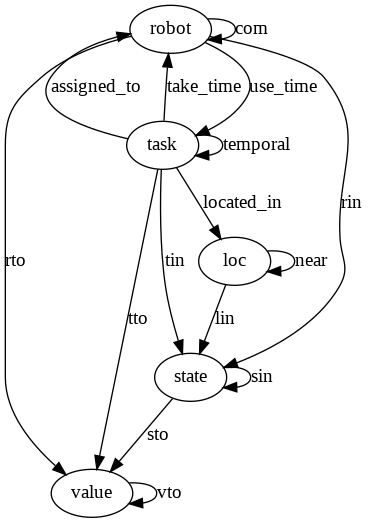

In [ ]:
plot_graph(g.metagraph(), 'example_graph')

img = cv2.imread('example_graph.png')
cv2_imshow(img)

We use `rin`, `tin`, `lin`, `sin` to distinguish the `in` edges with different source node type. Same applies on `to` edge types

Plot the full graph

In [ ]:
homo_g = dgl.to_homogeneous(g)
nx_g = dgl.to_networkx(homo_g, node_attrs=['_TYPE'], edge_attrs=['_TYPE'])

plt.figure(figsize=(15, 10))
pos = nx.circular_layout(nx_g)
node_color = homo_g.ndata['_TYPE']
nx.draw(nx_g, pos, with_labels = True, node_color=node_color, node_size=500, cmap=plt.cm.cool)
plt.show()

### Preparing the node features

The `hetgraph_node_helper` function takes a problem state and generates the corresponding node features as a dictionary keyed by node type names.

```python
def hetgraph_node_helper(number_of_nodes, curr_partialw, curr_partials,
                         locations, durations, map_width, num_robots, num_values):
    """
    Generate initial node features for hetgraph
    The input of hetgraph is a dictionary of node features for each type
        number_of_nodes: numer of nodes in half distance graph (halfDG)
        curr_partialw: partial solution/whole
        curr_partials: partial solution/seperate
        locations: np array locations
        durations: np array task durations
        map_width: map grid size
        num_robots: number of robots
        num_values: number of actions / Q values
    Return
        feat_dict: node features stored in a dict
    """
    feat_dict = {}
    ...
    ...
    return feat_dict
```

In [ ]:
from utils import hetgraph_node_helper

In [ ]:
feat_dict = hetgraph_node_helper(env.halfDG.number_of_nodes(),
                                              env.partialw,
                                              env.partials, env.loc, env.dur,
                                              map_width, env.num_robots,
                                              len(valid_tasks))

feat_dict_tensor = {}
for key in feat_dict:
    feat_dict_tensor[key] = torch.Tensor(feat_dict[key])

In [ ]:
for key in feat_dict_tensor:
    print(key, feat_dict_tensor[key].shape)

task torch.Size([19, 6])
loc torch.Size([9, 1])
robot torch.Size([5, 1])
state torch.Size([1, 4])
value torch.Size([12, 1])


In [ ]:
print(feat_dict_tensor['state'])

tensor([[18.,  1.,  9.,  5.]])


In [ ]:
# Q-value nodes are initialized as zero
print(feat_dict_tensor['value'])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


### Heterogenous Graph Attention Layer

The feature update process in a HetGAT layer is conducted in two steps: **per-edge-type message passing** followed by **per-node-type feature reduction**.

During message passing, each edge type uses a distinct weight matrix, $W_{edgeName} \in \mathbb{R}^{D \times S}$, to process the input feature from the source node, $N_{src}$, and sends the computation result to the destination node, $N_{dst}$'s mailbox. $S$ is the input feature dimension of $N_{src}$, and $D$ is the output feature dimension of $N_{dst}$.

```python
# in_dim: dict of input feature dimension for each node
# out_dim: dict of output feature dimension for each node
# cetypes: reutrn of G.canonical_etypes
class HeteroGATLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, cetypes,
                 l_alpha = 0.2, use_relu = True):
        super(HeteroGATLayer, self).__init__()
        ...

    # user defined functions for each edge type
    def attention_edge_type(self, edges):
        ...

    def message_edge_type(self, edges):
        ...

    def reduce_edge_type(self, nodes):
        ...

    '''
    Main forward pass
    '''
    def forward(self, g, feat_dict):
        ... 
        g.multi_update_all(funcs, 'sum')
        ...
        return ...
```

In [ ]:
from graph.hetgat import HeteroGATLayer

Equations of task nodes

\begin{align}
\mathrm{Scheduled~Task}~h_i^\prime &= \sigma \Big(\sum_{j \in {N_{temporal}(i)}} \alpha_{ij}^{temporal} (W_{temporal} h_j + W_{tempEdge} edge_{ji}) \Big)
\end{align}

\begin{align}
\mathrm{Unscheduled~Task}~h_i^\prime = \sigma \Big(\sum_{j \in {N_{temporal}(i)}} \alpha_{ij}^{temporal}& (W_{temporal} h_j + W_{tempEdge} edge_{ji}) \\ &       + \sum_{k \in {N_{useTime}(i)}}\alpha_{ik}^{useTime} (W_{useTime} h_k + W_{useTimeEdge}  edge_{ki}^{'} \Big)
\end{align}

\begin{align}
\alpha_{ij}^{temp.} = \mathrm{softmax}_j \bigg(\sigma^\prime \Big(\vec a_{temp.}^T \left[W_{temp.} \vec h_i || W_{temp.} \vec h_j || W_{tempEdge} edge_{ji}\right]\Big) \bigg)
\end{align}

\begin{align}
\alpha_{ik}^{useTime} = \mathrm{softmax}_k \bigg(\sigma^\prime \Big(\vec a_{useTime}^T \left[W_{temp.} \vec h_i || W_{useTime} \vec h_k || W_{useTimeEdge} edge_{ki}^{'}\right]\Big) \bigg)
\end{align}

Equations of robot nodes

\begin{align}
\mathrm{Robot}~h_i^\prime = \sigma \Big(\sum_{j \in {N_{assginedTo}(i)}} \alpha_{ij}^{assignedTo} W_{assignedTo} h_j \nonumber + \sum_{k \in {N_{comm.}(i)}} \alpha_{ik}^{comm.} W_{comm.} h_k \\ + \sum_{m \in {N_{takeTime}(i)}}\alpha_{im}^{takeTime} (W_{takeTime} h_m + W_{takeEdge}  edge_{mi}^{''} \Big)
\end{align}

\begin{align}
\alpha_{im}^{takeTime} = \mathrm{softmax}_m \bigg(\sigma^\prime \Big(\vec a_{takeTime}^T \Big[W_{comm.} \vec h_i || W_{takeTime} \vec h_m || W_{takeTimeEdge} edge_{mi}^{''}\Big]\Big) \bigg)
\end{align}

For edge types connecting the same type of nodes, the attention coefficients can be computed by:

\begin{align}
\alpha_{ij}^{edgeName} = \mathrm{softmax}_j \bigg( \sigma^\prime \Big(\vec a_{edgeName}^T\left[W_{edgeName} \vec h_i || W_{edgeName} \vec h_j \right]\Big) \bigg)
\end{align}

for edges where the source node, $h_j$, and destination node, $h_i$, are of different node types:

\begin{align}
\alpha_{ij}^{edgeName} = \mathrm{softmax}_j \bigg( \sigma^\prime \Big( \vec a_{edgeName}^T\left[W_{dstType} \vec h_i || W_{edgeName} \vec h_j \right]\Big) \bigg)
\end{align}

Equations of the rest

\begin{align}
\mathrm{Location}~h_i^\prime &= \sigma \Big(\sum_{j \in {N_{locateIn}(i)}} \alpha_{ij}^{locatedIn} W_{locatedIn} h_j + \sum_{k \in {N_{near}(i)}} \alpha_{ik}^{near} W_{near} h_k \Big)
\end{align}

\begin{align}
\mathrm{State}~h_i^\prime &= \sigma \Big(\sum_{j \in {N_{task,in}(i)}} \alpha_{ij}^{task,in} W_{task,in} h_j + \sum_{k \in {N_{robot,in}(i)}} \alpha_{ik}^{robot,in} W_{robot,in} h_k + \sum_{m \in {N_{loc.,in}(i)}} \alpha_{im}^{loc.,in} W_{loc.,in} h_m +  W_{state,in} h_i \Big)
\end{align}

\begin{align}
\mathrm{Value}~h_q^\prime  &= \sigma \Big(W_{task,to} h_t +W_{robot,to} h_r +  W_{state,to} h_s +  W_{value,to} h_q
\Bigg) 
\end{align}

### Multi-head attention

To stabilize the learning process, we utilize the multi-head attention proposed in [Veličković et al. "Graph attention networks"](https://arxiv.org/abs/1710.10903), adapting it to fit the heterogeneous case. We use $K$ independent HetGAT layers to compute node features in parallel and then merge the results as the multi-headed output via the concatenation operation for each multi-head layer in ScheduleNet, except for the last layer which employs averaging. 

Considering that ScheduleNet utilizes a fully convolutional structure where the last graph layer directly predicts Q-values as the 1-dimensional output feature of value nodes, merging multi-head results with concatenation is no longer viable for the last layer as it would give a K-dimensional output.

In [ ]:
import torch.nn as nn

# input similar to HeteroGATLayer
# merge = 'cat' or 'avg'
class MultiHeteroGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, cetypes,
                 num_heads, merge='cat'):
        super(MultiHeteroGATLayer, self).__init__()
        
        self.num_heads = num_heads
        self.merge = merge
        
        self.heads = nn.ModuleList()
        
        if self.merge == 'cat':        
            for i in range(self.num_heads):
                self.heads.append(HeteroGATLayer(in_dim, out_dim, cetypes))
        else:
            #self.relu = nn.ReLU()
            for i in range(self.num_heads):
                self.heads.append(HeteroGATLayer(in_dim, out_dim, cetypes,
                                                 use_relu = False))            

    def forward(self, g, feat_dict):
        tmp = {}
        for ntype in feat_dict:
            tmp[ntype] = []
            
        for i in range(self.num_heads):
            head_out = self.heads[i](g, feat_dict)
            
            for ntype in feat_dict:
                tmp[ntype].append(head_out[ntype])
        
        results = {}
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)  
            for ntype in feat_dict:
                results[ntype] = torch.cat(tmp[ntype], dim=1)
        else:
            # merge using average
            for ntype in feat_dict:
                # dont use relu as the predicted q scores are negative values
                #results[ntype] = self.relu(torch.mean(torch.stack(tmp[ntype]), dim=0))
                results[ntype] = torch.mean(torch.stack(tmp[ntype]), dim=0)
        
        return results

### The ScheduleNet Model

We build ScheduleNet model through stacking several HetGAT layers in series.

In [ ]:
class ScheduleNet4Layer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, cetypes, num_heads=4):
        super(ScheduleNet4Layer, self).__init__()
        
        hid_dim_input = {}
        for key in hid_dim:
            hid_dim_input[key] = hid_dim[key] * num_heads
        
        self.layer1 = MultiHeteroGATLayer(in_dim, hid_dim, cetypes, num_heads)
        self.layer2 = MultiHeteroGATLayer(hid_dim_input, hid_dim, cetypes, 
                                          num_heads)
        self.layer3 = MultiHeteroGATLayer(hid_dim_input, hid_dim, cetypes, 
                                          num_heads)
        self.layer4 = MultiHeteroGATLayer(hid_dim_input, out_dim, cetypes, 
                                          num_heads, merge='avg')
    
    '''
    input
        g: DGL heterograph
            number of Q score nodes = number of available actions
        feat_dict: dictionary of input features
    '''
    def forward(self, g, feat_dict):
        h1 = self.layer1(g, feat_dict)
        h2 = self.layer2(g, h1)
        h3 = self.layer3(g, h2)
        h4 = self.layer4(g, h3)
        
        return h4

### Load a Trained ScheduleNet model

Initialization

In [ ]:
# device = torch.device('cuda')
# use this for CPU-only mode
device = torch.device('cpu')

in_dim = {'task': 6,
          'loc': 1,
          'robot': 1,
          'state': 4,
          'value': 1
          }

hid_dim = {'task': 64,
           'loc': 64,
           'robot': 64,
           'state': 64,
           'value': 64
           }

out_dim = {'task': 32,
          'loc': 32,
          'robot': 32,
          'state': 32,
          'value': 1
          }

cetypes = [('task', 'temporal', 'task'),
           ('task', 'located_in', 'loc'),('loc', 'near', 'loc'),
           ('task', 'assigned_to', 'robot'), ('robot', 'com', 'robot'),
           ('task', 'tin', 'state'), ('loc', 'lin', 'state'), 
           ('robot', 'rin', 'state'), ('state', 'sin', 'state'), 
           ('task', 'tto', 'value'), ('robot', 'rto', 'value'), 
           ('state', 'sto', 'value'), ('value', 'vto', 'value'),
           ('task', 'take_time', 'robot'), ('robot', 'use_time', 'task')]

num_heads = 8

policy_net = ScheduleNet4Layer(in_dim, hid_dim, out_dim, cetypes, num_heads).to(device)
policy_net.eval()

ScheduleNet4Layer(
  (layer1): MultiHeteroGATLayer(
    (heads): ModuleList(
      (0): HeteroGATLayer(
        (fc): ModuleDict(
          (temporal): Linear(in_features=6, out_features=64, bias=True)
          (located_in): Linear(in_features=6, out_features=64, bias=True)
          (near): Linear(in_features=1, out_features=64, bias=True)
          (assigned_to): Linear(in_features=6, out_features=64, bias=True)
          (com): Linear(in_features=1, out_features=64, bias=True)
          (tin): Linear(in_features=6, out_features=64, bias=True)
          (lin): Linear(in_features=1, out_features=64, bias=True)
          (rin): Linear(in_features=1, out_features=64, bias=True)
          (sin): Linear(in_features=4, out_features=64, bias=True)
          (tto): Linear(in_features=6, out_features=64, bias=True)
          (rto): Linear(in_features=1, out_features=64, bias=True)
          (sto): Linear(in_features=4, out_features=64, bias=True)
          (vto): Linear(in_features=1, out_fe

Download trained checkpoint using [gdown](https://github.com/wkentaro/gdown) from a shared Google Drive [link](https://drive.google.com/file/d/1d9g_pv37gzkzJxmM9qPFROJpsqbt894q/view?usp=sharing)

In [ ]:
import gdown

# you can copy-and-paste a URL from Google Drive with fuzzy=True
url = "https://drive.google.com/file/d/1d9g_pv37gzkzJxmM9qPFROJpsqbt894q/view?usp=sharing"
output = "checkpoint.tar"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1d9g_pv37gzkzJxmM9qPFROJpsqbt894q
To: /content/checkpoint.tar
100%|██████████| 98.7M/98.7M [00:00<00:00, 291MB/s]


'checkpoint.tar'

Load checkpoint

In [ ]:
trained_checkpoint = '/content/checkpoint.tar'
print('Evaluating: ' + trained_checkpoint)
# this allow to load checkpoint trained via GPU to CPU-only
cp = torch.load(trained_checkpoint, map_location=device)
policy_net.load_state_dict(cp['policy_net_state_dict'])

Evaluating: /content/checkpoint.tar


<All keys matched successfully>

### Q-Value Prediction with ScheduleNet

In [ ]:
result = policy_net(g, feat_dict_tensor)

print(result.keys())

dict_keys(['task', 'loc', 'robot', 'state', 'value'])


In [ ]:
# Lx1
q_s_a = result['value']
pre = q_s_a[:,0].data.cpu().numpy()

print('Q Value predictions:', q_s_a)

Q Value predictions: tensor([[-53.1612],
        [-53.1609],
        [-52.6382],
        [-50.9590],
        [-52.4190],
        [-51.6206],
        [-52.4217],
        [-48.2379],
        [-52.5083],
        [-53.1688],
        [-49.2234],
        [-53.1615]], grad_fn=<MeanBackward1>)


In [ ]:
# get argmax on selected robot
a_idx = q_s_a.argmax()
idx = int(a_idx)
print(idx)

task_chosen = valid_tasks[idx]
print('Selected task:', task_chosen)

7
Selected task: 12


Output visualization

In [ ]:
import os
from scipy.special import softmax

# Plot the task distribution/prediction by ScheduleNet on current robot
def save_plot_act(step, robot, act_task, pre, task_chosen, locs, save_folder):
    num_task = len(act_task)
    
    index = np.arange(num_task)
    
    pre_sm = softmax(pre)
    
    # get label
    label = ['Task%02d' % task for task in act_task]
        
    plt.figure(figsize=(8,7))
    barlist = plt.bar(index, pre_sm)
    task_idx = np.argwhere(act_task==task_chosen)
    barlist[int(task_idx)].set_color('r')
    
    if pre_sm.max() > 0.67:
        plt.ylim(0, 1)
    else:
        plt.ylim(0, 1.5*pre_sm.max())
        
    plt.ylabel('Normazlied Prediction', fontsize=20)
    plt.xticks(index, label, fontsize=16, rotation=40)
    plt.title('Step %02d, Robot %d, Task%02d, Location (%d, %d)' % 
              (step, robot, task_chosen,
               locs[task_chosen-1][0], locs[task_chosen-1][1]), 
              fontsize=28)
    #plt.show()
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    figname = save_folder + '/step%02d_robot%02d_task%02d.png' % (step, robot, task_chosen)
    plt.savefig(figname)

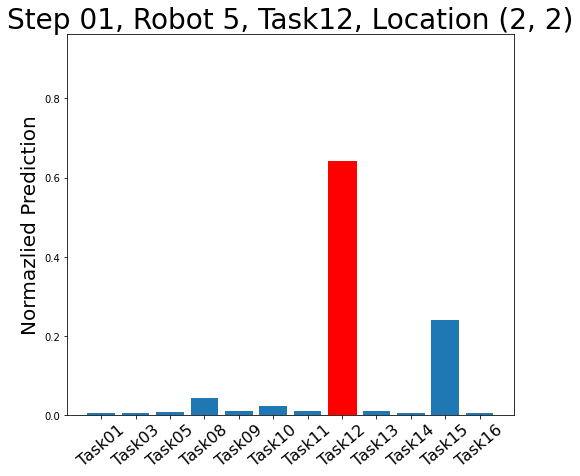

In [ ]:
save_plot_act(1, robot_chosen+1, valid_tasks, pre, task_chosen, env.loc, 'plots')

## Insert (Task, Agent) Assignment and Step Foward

In [ ]:
task_dur = env.dur[task_chosen-1][robot_chosen]
rt, reward, done = env.insert_robot(task_chosen, robot_chosen)
decision_step += 1
robots.update_status(task_chosen, robot_chosen, task_dur, t)

print('Step: %d,Time: %d, Robot %d, Task %02d, Dur %02d' %(decision_step, t, robot_chosen+1, task_chosen, task_dur))

Step: 1,Time: 0, Robot 5, Task 12, Dur 07


### Repeat for Next Step

Repeat the whole (task, robot) generation process unitll a whole schedule is generated, or an infeasible schedule occurs.

In [ ]:
# Attempt to pick another robot
next_robot_chosen = robots.pick_robot_by_min_dur(t, env, 'v1', exclude = [])
print('Robot #', next_robot_chosen+1, 'is picked')

Robot # 2 is picked


In [ ]:
# The set of valid tasks changes due to our previous scheduling decision
new_unsch_tasks = np.array(env.get_unscheduled_tasks(), dtype=np.int64)
print('Unscheduled tasks\n', new_unsch_tasks)
new_valid_tasks = np.array(env.get_valid_tasks(t), dtype=np.int64)
print('After filtering based on STN\n', new_valid_tasks)

Unscheduled tasks
 [ 1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17]
After filtering based on STN
 [ 5  9 10 13 15]


# Full Loop of Schedule Generation

In [ ]:
# initialize the scheduling enviroment with data files
env = SchedulingEnv(fname)

# initialize the robot teams
robots = RobotTeam(env.num_robots)

# parameters for logging the solving process
terminate = False
feas_count = 0

decision_step = 0

# size of location map, 3x3 is used
map_width = 3

In [ ]:
'''
Pick a task using GNN value function
    hetg: HetGraph in DGL
    act_task: unscheduled/available tasks
    pnet: trained GNN model
    ft_dict: input feature dict
    rj: robot chosen, not needed as hetg is based on the selected robot
    + also returns predictions of each task
'''
def gnn_pick_task(hetg, act_task, pnet, ft_dict):
    length = len(act_task)
    if length == 0:
        return -1, np.array([0])
       
    '''
    pick task using GNN
    '''
    #idx = np.argmin(tmp)
    if length == 1:
        idx = 0
        q_s_a_np = np.array([1])
    else:
        with torch.no_grad():
            result = pnet(hetg, ft_dict)
            # Lx1
            q_s_a = result['value']
            q_s_a_np = q_s_a[:,0].data.cpu().numpy()
            # get argmax on selected robot
            a_idx = q_s_a.argmax()
            idx = int(a_idx)
    
    task_chosen = act_task[idx]

    return task_chosen, q_s_a_np

In [ ]:
for t in range(env.num_tasks * 10):
    exclude = []
    robot_chosen = robots.pick_robot_by_min_dur(t, env, 'v1', exclude)
    # Repeatedly select robot with minimum duration until none is available
    while robot_chosen is not None:
        unsch_tasks = np.array(env.get_unscheduled_tasks(), dtype=np.int64)
        valid_tasks = np.array(env.get_valid_tasks(t), dtype=np.int64)
        
        if len(valid_tasks) > 0:
            g = build_hetgraph(env.halfDG, env.num_tasks, env.num_robots, env.dur,
                                map_width, np.array(env.loc, dtype=np.int64),
                                1.0, env.partials, unsch_tasks, robot_chosen,
                                valid_tasks)
            g = g.to(device)

            feat_dict = hetgraph_node_helper(env.halfDG.number_of_nodes(),
                                              env.partialw,
                                              env.partials, env.loc, env.dur,
                                              map_width, env.num_robots,
                                              len(valid_tasks))

            feat_dict_tensor = {}
            for key in feat_dict:
                feat_dict_tensor[key] = torch.Tensor(feat_dict[key]).to(device)
            
            task_chosen, pre = gnn_pick_task(g, valid_tasks, policy_net, 
                                        feat_dict_tensor)                
            
            if task_chosen >= 0:
                task_dur = env.dur[task_chosen-1][robot_chosen]
                rt, reward, done = env.insert_robot(task_chosen, robot_chosen)
                decision_step += 1
                robots.update_status(task_chosen, robot_chosen, task_dur, t)
                print('Step: %d,Time: %d, Robot %d, Task %02d, Dur %02d' 
                        %(decision_step, t, robot_chosen+1, task_chosen, task_dur))
                print(valid_tasks)
                print(pre)
                # uncomment the following if you want to set intermediate plots
                #save_plot_act(decision_step, robot_chosen+1, valid_tasks, 
                #              pre, task_chosen, env.loc, 'plots')
                '''
                Check for termination
                '''
                if rt == False:
                    print('Infeasible after %d insertions' % (len(env.partialw)-1))
                    terminate = True
                    break
                elif env.partialw.shape[0]==(env.num_tasks+1):
                    feas_count += 1
                    dqn_opt = env.min_makespan
                    print('Feasible solution found, min makespan: %f' 
                          % (env.min_makespan))
                    terminate = True
                    break

                # Attempt to pick another robot
                robot_chosen = robots.pick_robot_by_min_dur(t, env, 'v1', exclude)
            else:
                # No valid tasks for this robot, move to next
                exclude.append(robot_chosen)
                robot_chosen = robots.pick_robot_by_min_dur(t, env, 'v1', exclude)
        else:
            break
    
    if terminate:
        break

Step: 1,Time: 0, Robot 5, Task 12, Dur 07
[ 1  3  5  8  9 10 11 12 13 14 15 16]
[-53.161232 -53.160866 -52.638214 -50.958973 -52.419037 -51.620617
 -52.42168  -48.237938 -52.50826  -53.168793 -49.223366 -53.16153 ]
Step: 2,Time: 0, Robot 2, Task 15, Dur 05
[ 5  9 10 13 15]
[-49.385963 -49.265873 -48.482983 -49.311966 -46.203228]
Step: 3,Time: 0, Robot 3, Task 10, Dur 06
[ 5  9 10 13]
[-49.078297 -48.91997  -48.16586  -49.012863]
Step: 4,Time: 0, Robot 1, Task 09, Dur 02
[ 5  9 13]
[-52.58087 -52.34188 -52.48539]
Step: 5,Time: 0, Robot 4, Task 13, Dur 04
[13]
[1]
Step: 6,Time: 2, Robot 1, Task 05, Dur 05
[5]
[1]
Step: 7,Time: 7, Robot 5, Task 08, Dur 07
[ 1  3  8 11 14 16]
[-54.309605 -54.255707 -51.878338 -53.87545  -54.31675  -54.302856]
Step: 8,Time: 7, Robot 3, Task 11, Dur 01
[ 1  3 11 14 16]
[-52.840965 -52.798336 -52.45871  -52.850338 -52.844387]
Step: 9,Time: 7, Robot 1, Task 03, Dur 08
[ 1  3 14 16]
[-53.10416  -53.07085  -53.1493   -53.151638]
Step: 10,Time: 7, Robot 2, Task 0

Print the whole schedule

In [ ]:
robots.print_schedule()
print(env.partials[0])
print(env.partials[1])
print(env.partials[2])
print(env.partials[3])
print(env.partials[4])
print(env.partialw)

Robot 0
Task (9,0,2)
Task (5,2,7)
Task (3,7,15)
Task (7,22,31)
Task (4,31,35)
Robot 1
Task (15,0,5)
Task (1,7,14)
Task (6,29,34)
Robot 2
Task (10,0,6)
Task (11,7,8)
Task (14,15,22)
Robot 3
Task (13,0,4)
Robot 4
Task (12,0,7)
Task (8,7,14)
Task (2,14,21)
Task (16,21,29)
Task (17,29,31)
[0 9 5 3 7 4]
[ 0 15  1  6]
[ 0 10 11 14]
[ 0 13]
[ 0 12  8  2 16 17]
[ 0 12 15 10  9 13  5  8 11  3  1  2 14 16  7 17  6  4]


Demonstration video available at https://link.springer.com/article/10.1007/s10514-021-09997-2 (Scroll to the bottom to view the video).

<img src="https://phejohnwang.github.io/images/Fig13b.jpg" width="700">

# Training ScheduleNet

Under the MDP formulation, ScheduleNet can be trained by

* Reinforcement learning algorihtms from scratch
    * Can be time-consuming when solution space is huge for combinatorial optimization problems
    * Sparse reward (most permutations of the schedule are infeasible)

* Imitation learning algorihtms
    * Need expert solution on training problems

* A blend of RL & IL

## Imitation Learning



Here we leverage imitation learning methods that learn from high-quality schedules to accelerate the learning process for quick deployment.

* In real-world scheduling environments, we often have access to high-quality, manually-generated schedules from human experts who currently manage the logistics in manufacturing environments.

* It is practical to optimally solve small-scale problems with exact methods (e.g., Gurobi solver).

Given the **scalability** of the heterogeneous graph, we expect that exploiting such expert data on smaller problems to train the ScheduleNet can generalize well towards solving unseen problems, even in a larger scale.

In [3]:
from collections import namedtuple

'''
Transition for n-step
state
    curr_g: networkx graph updated with current solution
    curr_partials: partial solution as a list of numpy arrays (int)
        [sd0 sd1 ...]
            sd0: partial schedule of robot 0
            sd1: partial schedule of robot 1
            ......
    curr_partialw: partial schedule of all tasks selected
    locations: the location of each task
    durations: the duration of each task
action
    act_task: ti
    act_robot: rj
        append ti to rj's partial schedule
reward
    reward_n: total future discounted rewards
state after 1-step
    next_g: networkx graph
    next_partial: next partial solution
termination
    next_done: if True, means the next state is a termination state
        one episode finishes
        1. finish with feasible solution
        2. stop with infeasible partial
'''
Transition = namedtuple('Transition',
                        ('curr_g', 'curr_partials', 'curr_partialw',
                         'locs', 'durs',
                         'act_task', 'act_robot',
                         'reward_n', 'next_g', 'next_partials',
                         'next_partialw', 'next_done'))

Let $D_{ex}$ denote the expert dataset that contains all the state-action pairs of schedules either from exact solution methods or the domain experts. For each transition in $D_{ex}$, we calculate the total reward from current step $t$ until termination step $n$ using $R_t^{(n)} = \sum_{k=0}^{n-t} \gamma^k R_{t+k}$ and regress the corresponding Q-value predicted by ScheduleNet towards this value as shown in Equation~\ref{eq:lex}, where the supervised learning loss, $L_{ex}$, is computed as the mean squared error between $R_t^{(n)}$ and our current estimate on the expert action $u_{ex}$.

\begin{equation}
L_{ex} = \left\lVert Q(x_t,u_{ex})-R_t^{(n)}\right\rVert^2
\end{equation}

To fully exploit the expert data, we ground the predicted Q-values of alternative actions $u_{alt}$ (not selected by the expert) to a value below $R_t^{(n)}$, with $q_o$ a positive constant empirically picked as an offset, and $N_{alt}$ the number of alternative actions at step $t$. In accordance with the schedule generation scheme, $N_{alt}$ only considers actions involving the same robot selected by the expert.

\begin{equation}
L_{alt} = \frac{\sum\left\lVert Q(x,u_{alt})- \min\left(\left[\begin{array}{c} Q(x,u_{alt}) \\ R_t^{(n)} - q_o\end{array}\right]\right)\right\rVert^2}{N_{alt}}
\end{equation}

The min term ensures that the gradient propagates through all the unselected actions that have Q-values predicted by ScheduleNet to be higher than $R_t^{(n)}-q_o$.

The total supervised loss is shown below, where $L_2$ is the L2 regularization term on the network weights, and $\lambda_1, \lambda_2$ are weighting parameters assigned to different loss terms empirically.

\begin{equation}
L_{total} = L_{ex} + \lambda_1 L_{alt} + \lambda_2 L_2
\end{equation}

In [ ]:
def train(...)    
    ...
    outputs = policy_net(g, feat_dict_tensor)
    q_pre = outputs['value']

    '''
    Calculate TD loss & LfD loss at the same time
    '''
    if num_actions > 1:
        # q value for alterantive actions                
        offset = 5.0
        target_list = np.full((num_actions, 1), 
                              batch.reward_n[i] - offset, dtype=np.float32)

        LfD_weights = np.full((num_actions, 1), 
                              0.9/(num_actions-1), dtype=np.float32)
              
        q_s_a_alt_target1 = q_pre.clone().detach()
        q_s_a_alt_target2 = torch.tensor(target_list).to(device)
        q_s_a_alt_target = torch.min(q_s_a_alt_target1, q_s_a_alt_target2)
        
        # q value for expert action
        expert_idx = 0
        for j in range(num_actions):
            if unsch_tasks[j] == batch.act_task[i]:
                expert_idx = j
                break
        q_s_a_alt_target[expert_idx, 0] = batch.reward_n[i]
        LfD_weights[expert_idx, 0] = 1.0
    else:
        # num_actions == 1
        target_list = np.full((1, 1), batch.reward_n[i], dtype=np.float32)

        LfD_weights = np.full((1, 1), 1.0, dtype=np.float32)
        q_s_a_alt_target = torch.tensor(target_list).to(device)
        
    loss_SL = F.mse_loss(q_pre, q_s_a_alt_target, reduction='none')
    LfD_weights = torch.Tensor(LfD_weights).to(device)
    loss_SL = loss_SL * LfD_weights

    ...

Full training code is provided as `lr_scheduler_train.py`

# References

1. Working with Heterogeneous Graphs, DGL documentation: https://docs.dgl.ai/en/0.6.x/tutorials/basics/5_hetero.html

2. User Guide, DGL documentation: https://docs.dgl.ai/en/latest/guide/index.html

3. Shi et al. "A survey of heterogeneous information network analysis." *IEEE Transactions on Knowledge and Data Engineering* 29, no. 1 (2016): 17-37. https://arxiv.org/pdf/1511.04854.pdf

4. Schlichtkrull et al. "Modeling relational data with graph convolutional networks." In *European Semantic Web Conference*, pp. 593-607. Springer, Cham, 2018. https://link.springer.com/chapter/10.1007/978-3-319-93417-4_38

5. Wang et al. "Heterogeneous graph attention networks for scalable multi-robot scheduling with temporospatial constraints". Autonomous Robots (2021), 1–20. https://link.springer.com/article/10.1007/s10514-021-09997-2